In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
sns.set_context("talk")


## Exclusions and Outliers
-- 3 subject sub-5f706a963b6ac2627a4bb3b5 & sub-611c31c77df20ecc6881cc44 reported 0 variance distributions

In [2]:


sub_df=[]
subs=os.listdir('../bids')
for sub in subs:
    #print(sub)
    if sub not in['subjects.tsv','sub-5f706a963b6ac2627a4bb3b5','sub-611c31c77df20ecc6881cc44',
                 'sub-5d8aa95dd06260000179442b']:#reported 0 variance distributions
        mem=pd.read_csv('../bids/%s/%s_mem-report.tsv'%(sub,sub),sep='\t')
        if len(mem.groupby('dist').mean())<2:
            print("didn't answer for all dists",sub)
        else:
            vals=[]
            for dist in ['narrow','wide','skew']:
                vals.append(len(mem[(mem['dist']=='wide')&(mem['value']>0)]))
            #if any([val<2 for val in vals]):
                #print("non zero std ",sub)
            else:
                mem.percent=mem.percent.astype(int)

                mem['value']=mem['value'].astype(int)
                mem.loc[mem['value'] < 0, 'value'] = 0
                mem=pd.DataFrame(mem.values.repeat(mem.value, axis=0), columns=mem.columns)
                mem.percent=mem.percent.astype(int)
                mem['order']=mem['order'].astype(int)
                mem['value']=mem['value'].astype(int)
                mem=mem[['dist','percent','value','order']]
                O_df=mem.groupby('dist').mean().reset_index()
                order_var=O_df[O_df['dist']=='wide']['order'].values-O_df[O_df['dist']=='narrow']['order'].values
                if len(mem.groupby('dist').mean())>2:
                    mem_df=pd.DataFrame()
                    mem_df['dist']=['narrow','skew','wide']
                    mem_df['narrow_first']=order_var[0]
                    mem_df['means']=mem.groupby('dist').mean()['percent'].values
                    mem_df['stds']=mem.groupby('dist').std()['percent'].values
                    mem_df['skew']=mem.groupby('dist').skew()['percent'].values
                    mem_df['sub']=(sub)
                    sub_df.append(mem_df)
                else:
                    #print(sub)
                    pass
sub_df=pd.concat(sub_df)
sub_df=sub_df.reset_index()
sub_df

,index,dist,narrow_first,means,stds,skew,sub
0,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2
1,1,skew,-1.0,71.764706,14.677915,-0.209272,sub-5858b2ca83a02d0001e38fd2
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2
3,0,narrow,-1.0,59.166667,19.286516,0.505403,sub-5c7e764fa7432a00169e1499
4,1,skew,-1.0,47.058824,27.102746,-0.458493,sub-5c7e764fa7432a00169e1499
...,...,...,...,...,...,...,...
880,1,skew,-1.0,68.000000,15.491933,0.412401,sub-5fea025ffeba314a5f1fbda8
881,2,wide,-1.0,50.000000,32.366944,0.000000,sub-5fea025ffeba314a5f1fbda8
882,0,narrow,1.0,51.538462,36.601586,-0.068506,sub-614fca8245a450546842e487
883,1,skew,1.0,68.947368,22.581885,-1.439625,sub-614fca8245a450546842e487


In [3]:
import statsmodels.api as sm
row=[]
exclude=[]
for sub in sub_df['sub'].unique():
    df=pd.read_csv('../bids/%s/%s_task-amb_run-1_events.tsv'%(sub,sub),
                   sep='\t')
    if any(df[df['choice']=='risk']['per']==0):
        exclude.append(sub)
    elif any(df[df['choice']=='Ambiguity']['per']==1):
        exclude.append(sub)
    
print("Out of %s participants an additional %s were excluded do to choice checks"%(len(
    sub_df['sub'].unique()),len(exclude)))
print("This leaves us with a total of %s"%(len(
    sub_df['sub'].unique())-len(exclude)))
sub_df=sub_df[~sub_df['sub'].isin(exclude)]
df=pd.read_csv('../bids/subjects.tsv',sep='\t')
df=df[df['sub'].isin(sub_df['sub'].values)].reset_index()
sub_df=sub_df.merge(df,left_on='sub',right_on='sub')
sub_df.head()

Out of 295 participants an additional 18 were excluded do to choice checks
This leaves us with a total of 277


,index_x,dist,narrow_first,means,stds,skew,sub,index_y,USIDep,AQ_Social,...,AADIS4,AADIS4.1,AADIS5,AADIS6,AADIS7,AADIS8,AADIS9,AADIS10,AADIS11,AADIS12
0,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2,103,1,4.2,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used
1,1,skew,-1.0,71.764706,14.677915,-0.209272,sub-5858b2ca83a02d0001e38fd2,103,1,4.2,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2,103,1,4.2,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used
3,0,narrow,-1.0,59.166667,19.286516,0.505403,sub-5c7e764fa7432a00169e1499,385,1,5.2,...,Several Times Daily,Once or Twice,Once or Twice,Once or Twice,Never Used,Once or Twice,Never Used,Never Used,Never Used,Once or Twice
4,1,skew,-1.0,47.058824,27.102746,-0.458493,sub-5c7e764fa7432a00169e1499,385,1,5.2,...,Several Times Daily,Once or Twice,Once or Twice,Once or Twice,Never Used,Once or Twice,Never Used,Never Used,Never Used,Once or Twice


In [4]:
df=pd.read_csv('../bids/subjects.tsv',sep='\t')
df

,sub,USIDep,AQ_Social,AQ_AttnDet,AQ_AttnSwitch,AQ_Commun,AQ_Imagine,AQ_total,none,age,...,AADIS4,AADIS4.1,AADIS5,AADIS6,AADIS7,AADIS8,AADIS9,AADIS10,AADIS11,AADIS12
0,sub-5f8a1fcf2773900d456a3e70,5,6.8,4.8,7.2,5.6,6.2,30.6,NaN,31,...,Once or Twice,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used
1,sub-6428f7ac297e312f7262d93b,1,7.4,4.2,7.4,6.0,4.6,29.6,NaN,59,...,Several Times a Month,Never Used,Never Used,Never Used,Never Used,Once or Twice,Never Used,Once or Twice,Never Used,Never Used
2,sub-6310a8e72d2a091bb08a0c97,1,6.0,5.2,6.2,4.0,4.2,25.6,NaN,31,...,Once or Twice,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used
3,sub-60c93f189082587ea79ce324,1,6.4,7.8,6.4,4.0,3.8,28.4,NaN,26,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used
4,sub-5d793a152df8ed001645ed7f,4,5.6,5.8,6.4,4.8,6.8,29.4,NaN,41,...,Several Times Daily,Once or Twice,Once or Twice,Once or Twice,Once or Twice,Never Used,Never Used,Once or Twice,Never Used,Once or Twice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,sub-5d6d26703fb106001bed4b6c,3,4.2,6.8,5.6,3.8,4.0,24.4,NaN,61,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used
508,sub-5e16c978783225c8108ef055,0,6.8,6.2,6.0,5.0,6.0,30.0,NaN,61,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used
509,sub-5de301515253b03390043d12,0,5.0,4.8,5.8,5.8,3.6,25.0,NaN,59,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used
510,sub-5e2b74daae56b71b9d24d89b,1,4.4,6.4,4.8,5.0,6.2,26.8,NaN,67,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used


## Hypothesis 3 a:
- Autistic traits measured by the autism quotient, will be negatively correlated ambiguity aversion. 
- Choice ~ Probability + Autistic Trait 

In [5]:
sub_df[sub_df['sub']==sub][['age','AQ_Social','AQ_AttnDet','AQ_AttnSwitch','AQ_Commun','AQ_Imagine','AQ_total']].values[0]

array([62. ,  6.2,  3.8,  6.6,  5.6,  5.8, 28. ])

In [6]:
amb_df=[]
for sub in sub_df['sub'].unique():
    #print(sub)
    amb=pd.read_csv('../bids/%s/%s_task-amb_run-1_events.tsv'%(sub,sub),sep='\t')
    amb['sub']=sub
    amb['order']=sub_df[sub_df['sub']==sub]['narrow_first'].values[0]
    amb[['AQ_Social','AQ_AttnDet','AQ_AttnSwitch','AQ_Commun','AQ_Imagine','AQ_total']]=sub_df[
        sub_df['sub']==sub][
        ['AQ_Social','AQ_AttnDet','AQ_AttnSwitch','AQ_Commun','AQ_Imagine','AQ_total']].values[0]
    
    amb_df.append(amb)
        
amb_df=pd.concat(amb_df)
print("no NA values for choice ",amb_df['choice'].unique())
amb_df['choose_risk']=amb_df['choice']=='risk'
print("no NA values for Amb ",amb_df['Amb'].unique())
amb_df['full_A']=amb_df['Amb']=='[0,1]'
print("no NA values for dist ",amb_df['dist'].unique())
amb_df['wide_dist']=amb_df['dist']=='wide'
print("NA values for percent ",any(amb_df['per'].isna()))


amb_df.head()

no NA values for choice  ['risk' 'Ambiguous']
no NA values for Amb  ['[0.25,0.75]' '[0,1]']
no NA values for dist  ['wide' 'narrow' 'skew']
NA values for percent  False


,Blocktype,tnum,rt,color,per,Amb,choice,dist,side,response,...,order,AQ_Social,AQ_AttnDet,AQ_AttnSwitch,AQ_Commun,AQ_Imagine,AQ_total,choose_risk,full_A,wide_dist
0,Ambiguity,0.0,1666.0,blue,0.50,"[0.25,0.75]",risk,wide,right,j,...,-1.0,4.2,6.6,5.8,5.0,4.2,25.8,True,False,True
1,Ambiguity,1.0,2371.0,blue,0.41,"[0.25,0.75]",Ambiguous,wide,right,f,...,-1.0,4.2,6.6,5.8,5.0,4.2,25.8,False,False,True
2,Ambiguity,2.0,1480.0,blue,0.46,"[0.25,0.75]",risk,wide,left,f,...,-1.0,4.2,6.6,5.8,5.0,4.2,25.8,True,False,True
3,Ambiguity,3.0,1457.0,blue,0.42,"[0.25,0.75]",Ambiguous,wide,right,f,...,-1.0,4.2,6.6,5.8,5.0,4.2,25.8,False,False,True
4,Ambiguity,4.0,1914.0,blue,0.43,"[0.25,0.75]",Ambiguous,wide,right,f,...,-1.0,4.2,6.6,5.8,5.0,4.2,25.8,False,False,True


/home/strange/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


####### AQ_Social   wide #######
Formula: choose_risk~per+AQ_Social+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2324.664 	 AIC: 4657.329

Random effects:

            Name     Var    Std
sub  (Intercept)  11.701  3.421

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-10.214,-12.348,-8.079,1.089,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.00,0.000,-9.380,0.000,***
per,23.314,20.724,25.904,1.321,1.333900e+10,1.001034e+09,1.777452e+11,1.000,1.00,1.000,17.645,0.000,***
AQ_Social,-0.222,-0.533,0.090,0.159,8.010000e-01,5.870000e-01,1.094000e+00,0.445,0.37,0.522,-1.396,0.163,


####### AQ_AttnDet   wide #######
Formula: choose_risk~per+AQ_AttnDet+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2325.183 	 AIC: 4658.366

Random effects:

            Name     Var    Std
sub  (Intercept)  11.737  3.426

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-12.493,-15.009,-9.978,1.284,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-9.733,0.000,***
per,23.302,20.718,25.886,1.318,1.317775e+10,9.945224e+08,1.746095e+11,1.000,1.000,1.000,17.674,0.000,***
AQ_AttnDet,0.167,-0.175,0.510,0.175,1.182000e+00,8.390000e-01,1.665000e+00,0.542,0.456,0.625,0.958,0.338,


####### AQ_AttnSwitch   wide #######
Formula: choose_risk~per+AQ_AttnSwitch+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2325.575 	 AIC: 4659.151

Random effects:

            Name     Var    Std
sub  (Intercept)  11.778  3.432

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.955,-14.852,-9.058,1.478,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.00,-8.089,0.000,***
per,23.302,20.717,25.886,1.319,1.317755e+10,9.941973e+08,1.746614e+11,1.000,1.000,1.00,17.672,0.000,***
AQ_AttnSwitch,0.077,-0.335,0.489,0.210,1.080000e+00,7.150000e-01,1.630000e+00,0.519,0.417,0.62,0.366,0.714,


####### AQ_Commun   wide #######
Formula: choose_risk~per+AQ_Commun+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2325.207 	 AIC: 4658.414

Random effects:

            Name     Var    Std
sub  (Intercept)  11.744  3.427

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-10.508,-12.885,-8.131,1.213,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-8.666,0.000,***
per,23.304,20.716,25.892,1.321,1.320615e+10,9.925550e+08,1.757106e+11,1.000,1.000,1.000,17.648,0.000,***
AQ_Commun,-0.188,-0.582,0.207,0.201,8.290000e-01,5.590000e-01,1.230000e+00,0.453,0.358,0.552,-0.932,0.351,


####### AQ_Imagine   wide #######
Formula: choose_risk~per+AQ_Imagine+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2325.618 	 AIC: 4659.237

Random effects:

            Name     Var    Std
sub  (Intercept)  11.779  3.432

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.241,-13.721,-8.761,1.265,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-8.883,0.000,***
per,23.299,20.711,25.888,1.321,1.314539e+10,9.877056e+08,1.749523e+11,1.000,1.000,1.000,17.642,0.000,***
AQ_Imagine,-0.049,-0.486,0.388,0.223,9.520000e-01,6.150000e-01,1.473000e+00,0.488,0.381,0.596,-0.220,0.826,


####### AQ_total   wide #######
Formula: choose_risk~per+AQ_total+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2325.563 	 AIC: 4659.127

Random effects:

            Name     Var    Std
sub  (Intercept)  11.775  3.431

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-10.862,-14.144,-7.581,1.674,0.000000e+00,0.000000e+00,1.000000e-03,0.000,0.000,0.001,-6.489,0.000,***
per,23.301,20.716,25.886,1.319,1.316958e+10,9.927283e+08,1.747081e+11,1.000,1.000,1.000,17.666,0.000,***
AQ_total,-0.022,-0.130,0.086,0.055,9.780000e-01,8.780000e-01,1.090000e+00,0.494,0.467,0.522,-0.398,0.691,


Formula: choose_risk~per+ASD+(1+per|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2163.533 	 AIC: 4339.066

Random effects:

            Name       Var     Std
sub  (Intercept)   336.061  18.332
sub          per  1288.088  35.890

             IV1  IV2   Corr
sub  (Intercept)  per -0.957

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-27.815,-31.832,-23.799,2.049,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-13.573,0.000,***
per,57.898,49.852,65.945,4.106,1.396354e+25,4.470718e+21,4.361276e+28,1.000,1.000,1.000,14.103,0.000,***
ASDTRUE,-0.398,-1.826,1.030,0.728,6.720000e-01,1.610000e-01,2.800000e+00,0.402,0.139,0.737,-0.547,0.585,


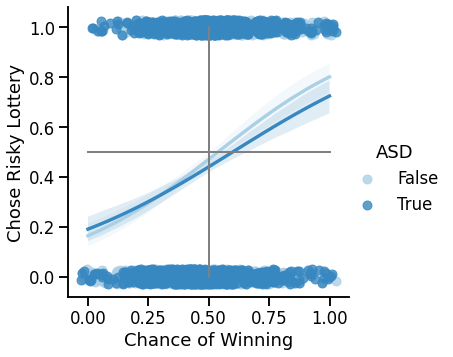

####### AQ_Social   narrow #######
Formula: choose_risk~per+AQ_Social+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2263.408 	 AIC: 4534.816

Random effects:

            Name     Var    Std
sub  (Intercept)  11.737  3.426

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-10.831,-12.972,-8.690,1.092,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-9.917,0.000,***
per,24.989,22.395,27.583,1.323,7.122234e+10,5.322837e+09,9.529921e+11,1.000,1.000,1.000,18.883,0.000,***
AQ_Social,-0.091,-0.402,0.220,0.159,9.130000e-01,6.690000e-01,1.246000e+00,0.477,0.401,0.555,-0.575,0.565,


####### AQ_AttnDet   narrow #######
Formula: choose_risk~per+AQ_AttnDet+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2263.553 	 AIC: 4535.106

Random effects:

            Name     Var    Std
sub  (Intercept)  11.757  3.429

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.570,-14.000,-9.139,1.240,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-9.329,0.00,***
per,24.993,22.405,27.581,1.321,7.150527e+10,5.372712e+09,9.516616e+11,1.000,1.000,1.000,18.925,0.00,***
AQ_AttnDet,0.035,-0.308,0.379,0.175,1.036000e+00,7.350000e-01,1.460000e+00,0.509,0.424,0.594,0.201,0.84,


####### AQ_AttnSwitch   narrow #######
Formula: choose_risk~per+AQ_AttnSwitch+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2263.197 	 AIC: 4534.393

Random effects:

            Name     Var    Std
sub  (Intercept)  11.726  3.424

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-12.485,-15.373,-9.596,1.474,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-8.472,0.000,***
per,24.995,22.404,27.585,1.322,7.161242e+10,5.368944e+09,9.551858e+11,1.000,1.000,1.000,18.910,0.000,***
AQ_AttnSwitch,0.182,-0.231,0.595,0.211,1.200000e+00,7.940000e-01,1.813000e+00,0.545,0.443,0.645,0.864,0.387,


####### AQ_Commun   narrow #######
Formula: choose_risk~per+AQ_Commun+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2263.535 	 AIC: 4535.071

Random effects:

            Name     Var    Std
sub  (Intercept)  11.753  3.428

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.069,-13.432,-8.706,1.206,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.00,0.000,-9.180,0.000,***
per,24.991,22.410,27.573,1.317,7.138793e+10,5.400121e+09,9.437262e+11,1.000,1.00,1.000,18.973,0.000,***
AQ_Commun,-0.055,-0.449,0.338,0.201,9.460000e-01,6.380000e-01,1.403000e+00,0.486,0.39,0.584,-0.275,0.783,


####### AQ_Imagine   narrow #######
Formula: choose_risk~per+AQ_Imagine+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2263.570 	 AIC: 4535.140

Random effects:

            Name     Var    Std
sub  (Intercept)  11.758  3.429

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.437,-13.880,-8.995,1.246,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-9.177,0.000,***
per,24.993,22.403,27.582,1.321,7.147586e+10,5.364254e+09,9.523782e+11,1.000,1.000,1.000,18.916,0.000,***
AQ_Imagine,0.017,-0.419,0.453,0.222,1.017000e+00,6.580000e-01,1.573000e+00,0.504,0.397,0.611,0.076,0.939,


####### AQ_total   narrow #######
Formula: choose_risk~per+AQ_total+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2263.572 	 AIC: 4535.145

Random effects:

            Name     Var    Std
sub  (Intercept)  11.759  3.429

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.410,-14.705,-8.114,1.681,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000,0.000,-6.786,0.000,***
per,24.993,22.399,27.586,1.323,7.147228e+10,5.342930e+09,9.560834e+11,1.0,1.000,1.000,18.887,0.000,***
AQ_total,0.002,-0.107,0.111,0.056,1.002000e+00,8.990000e-01,1.117000e+00,0.5,0.473,0.528,0.035,0.972,


Formula: choose_risk~per+ASD+(1+per|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2049.060 	 AIC: 4110.120

Random effects:

            Name       Var     Std
sub  (Intercept)   425.537  20.629
sub          per  1599.969  40.000

             IV1  IV2   Corr
sub  (Intercept)  per -0.978

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-29.151,-33.423,-24.879,2.180,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-13.374,0.000,***
per,62.727,54.040,71.415,4.432,1.746175e+27,2.945692e+23,1.035114e+31,1.000,1.000,1.000,14.152,0.000,***
ASDTRUE,-0.264,-1.456,0.928,0.608,7.680000e-01,2.330000e-01,2.529000e+00,0.434,0.189,0.717,-0.434,0.664,


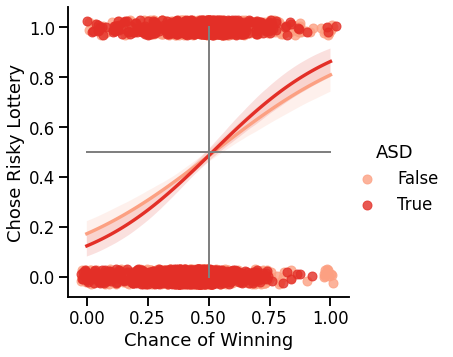

####### AQ_Social   skew #######
Formula: choose_risk~per+AQ_Social+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2269.853 	 AIC: 4547.705

Random effects:

            Name     Var    Std
sub  (Intercept)  14.297  3.781

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.458,-13.780,-9.136,1.185,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.00,-9.672,0.000,***
per,26.702,23.952,29.453,1.403,3.950897e+11,2.523979e+10,6.184515e+12,1.000,1.000,1.00,19.026,0.000,***
AQ_Social,-0.424,-0.769,-0.078,0.176,6.550000e-01,4.640000e-01,9.250000e-01,0.396,0.317,0.48,-2.404,0.016,*


####### AQ_AttnDet   skew #######
Formula: choose_risk~per+AQ_AttnDet+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2271.639 	 AIC: 4551.278

Random effects:

            Name     Var    Std
sub  (Intercept)  14.524  3.811

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-15.645,-18.490,-12.800,1.451,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-10.780,0.000,***
per,26.709,23.961,29.457,1.402,3.976374e+11,2.546966e+10,6.207994e+12,1.000,1.000,1.000,19.049,0.000,***
AQ_AttnDet,0.290,-0.091,0.671,0.194,1.337000e+00,9.130000e-01,1.957000e+00,0.572,0.477,0.662,1.492,0.136,


####### AQ_AttnSwitch   skew #######
Formula: choose_risk~per+AQ_AttnSwitch+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2272.720 	 AIC: 4553.440

Random effects:

            Name     Var    Std
sub  (Intercept)  14.623  3.824

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-13.484,-16.674,-10.294,1.628,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-8.284,0.000,***
per,26.684,23.936,29.431,1.402,3.877191e+11,2.485244e+10,6.048747e+12,1.000,1.000,1.000,19.036,0.000,***
AQ_AttnSwitch,-0.063,-0.521,0.395,0.233,9.390000e-01,5.940000e-01,1.484000e+00,0.484,0.373,0.597,-0.270,0.787,


####### AQ_Commun   skew #######
Formula: choose_risk~per+AQ_Commun+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2271.491 	 AIC: 4550.982

Random effects:

            Name     Var    Std
sub  (Intercept)  14.483  3.806

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-12.040,-14.648,-9.432,1.331,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-9.048,0.000,***
per,26.692,23.941,29.443,1.404,3.909261e+11,2.496716e+10,6.120970e+12,1.000,1.000,1.000,19.017,0.000,***
AQ_Commun,-0.355,-0.793,0.083,0.224,7.010000e-01,4.520000e-01,1.086000e+00,0.412,0.311,0.521,-1.589,0.112,


####### AQ_Imagine   skew #######
Formula: choose_risk~per+AQ_Imagine+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2271.682 	 AIC: 4551.363

Random effects:

            Name     Var    Std
sub  (Intercept)  14.506  3.809

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-12.126,-14.808,-9.445,1.368,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.0,0.000,-8.864,0.000,***
per,26.685,23.932,29.437,1.405,3.881479e+11,2.474483e+10,6.088497e+12,1.00,1.0,1.000,18.999,0.000,***
AQ_Imagine,-0.362,-0.847,0.123,0.247,6.960000e-01,4.290000e-01,1.130000e+00,0.41,0.3,0.531,-1.464,0.143,


####### AQ_total   skew #######
Formula: choose_risk~per+AQ_total+(1|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2271.995 	 AIC: 4551.990

Random effects:

            Name     Var    Std
sub  (Intercept)  14.532  3.812

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-11.753,-15.354,-8.153,1.837,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-6.398,0.000,***
per,26.680,23.930,29.431,1.403,3.865175e+11,2.470163e+10,6.048012e+12,1.000,1.000,1.000,19.013,0.000,***
AQ_total,-0.076,-0.196,0.045,0.061,9.270000e-01,8.220000e-01,1.046000e+00,0.481,0.451,0.511,-1.233,0.217,


Formula: choose_risk~per+ASD+(1+per|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2125.680 	 AIC: 4263.360

Random effects:

            Name      Var     Std
sub  (Intercept)  283.546  16.839
sub          per  856.286  29.262

             IV1  IV2   Corr
sub  (Intercept)  per -0.939

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-28.182,-32.096,-24.268,1.997,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,0.000,-14.113,0.00,***
per,55.731,48.448,63.013,3.716,1.598132e+24,1.098664e+21,2.324663e+27,1.000,1.000,1.000,14.999,0.00,***
ASDTRUE,-1.715,-3.260,-0.169,0.789,1.800000e-01,3.800000e-02,8.450000e-01,0.153,0.037,0.458,-2.174,0.03,*


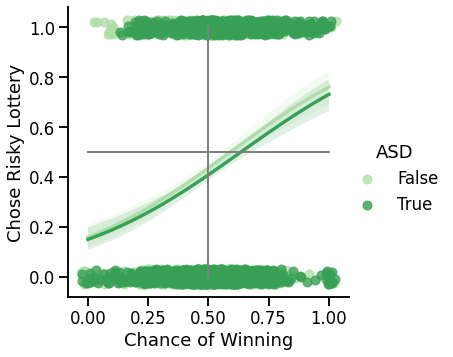

In [7]:
from pymer4.models import Lmer
model_df=amb_df[amb_df['full_A']==True]
model_df['ASD']=model_df['AQ_total']>model_df.AQ_total.quantile()


aqs=[aq for aq in model_df.columns if aq.startswith('AQ_')]

for dist in model_df['dist'].unique():
    tmp=model_df[model_df['dist'].isin([dist])]
    for aq in aqs:
        print("####### %s   %s #######"%(aq,dist))
        model = Lmer("choose_risk  ~ per+%s  + (1|sub)"%(aq),
                     data=tmp, family = 'binomial')
        display(model.fit(robust='hcl'))
        
        if aq=='AQ_total':
            if dist=='narrow':
                color='Reds'
            if dist=='wide':
                color="Blues"
            if dist=='skew':
                color="Greens"
            model = Lmer("choose_risk  ~ per+ASD  + (1+per|sub)",
                     data=tmp, family = 'binomial')
            display(model.fit(robust='hcl'))
            sns.lmplot(x='per',y='choose_risk',logistic=True, data=tmp,hue='ASD',x_jitter=0.03,y_jitter=0.03,
                      palette=color)
            plt.plot([0,1], [0.5,0.5], linewidth=2,color='grey')
            plt.plot([.50,.50], [0,1], linewidth=2,color='grey')
            plt.xlabel('Chance of Winning')
            plt.ylabel('Chose Risky Lottery')
            plt.show()

## Hypothesis 3 b:
- Autistic traits will be negatively correlated with the variance of individual’s reported belief about the distribution of probabilities.

In [8]:
model_df=amb_df[(amb_df['full_A']==True)&(amb_df['dist']=='narrow')]

model = Lmer("choose_risk  ~ per+(1+per|sub)",
             data=model_df, family = 'binomial')

model.fit(robust='hcl')

fixedEFF_df=model.fixef.reset_index()
fixedEFF_df=fixedEFF_df.rename(columns={'index':'sub'})
sub_df=sub_df.merge(fixedEFF_df[['sub','(Intercept)','per']],on='sub')
sub_df.head()

Formula: choose_risk~per+(1+per|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2049.153 	 AIC: 4108.307

Random effects:

            Name       Var     Std
sub  (Intercept)   426.361  20.649
sub          per  1601.867  40.023

             IV1  IV2   Corr
sub  (Intercept)  per -0.978

Fixed effects:



,index_x,dist,narrow_first,means,stds,skew,sub,index_y,USIDep,AQ_Social,...,AADIS5,AADIS6,AADIS7,AADIS8,AADIS9,AADIS10,AADIS11,AADIS12,(Intercept),per
0,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2,103,1,4.2,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,-48.552572,96.702183
1,1,skew,-1.0,71.764706,14.677915,-0.209272,sub-5858b2ca83a02d0001e38fd2,103,1,4.2,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,-48.552572,96.702183
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2,103,1,4.2,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,-48.552572,96.702183
3,0,narrow,-1.0,59.166667,19.286516,0.505403,sub-5c7e764fa7432a00169e1499,385,1,5.2,...,Once or Twice,Once or Twice,Never Used,Once or Twice,Never Used,Never Used,Never Used,Once or Twice,-48.949229,98.937704
4,1,skew,-1.0,47.058824,27.102746,-0.458493,sub-5c7e764fa7432a00169e1499,385,1,5.2,...,Once or Twice,Once or Twice,Never Used,Once or Twice,Never Used,Never Used,Never Used,Once or Twice,-48.949229,98.937704


/home/strange/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/strange/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/strange/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

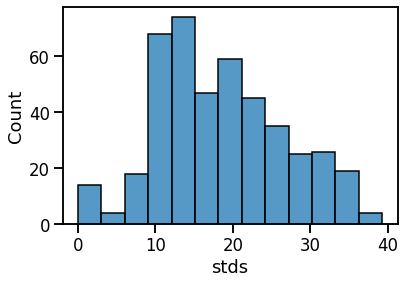

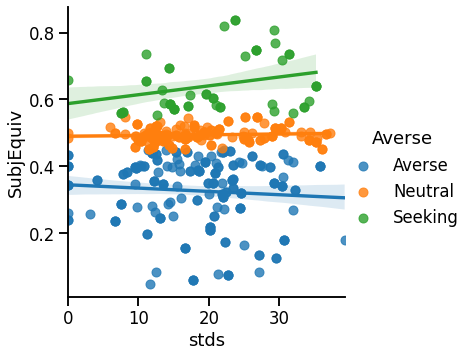

In [9]:
plt_df=sub_df[sub_df['dist']=='narrow']
plt_df['AQ_Cutoff']=plt_df['AQ_total']>32

plt_df['SubjEquiv']=np.divide(-plt_df['(Intercept)'],plt_df['per'])
plt_df['Averse']=pd.cut(plt_df['SubjEquiv'],bins=[0,.45,.55,1.00],labels=['Averse','Neutral','Seeking'])

plt_df=plt_df[(plt_df['SubjEquiv']>0)&(plt_df['SubjEquiv']<1)]

plt_df['var_high']=pd.cut(plt_df['stds'],bins=[0,10,20,30,40])#,labels=['low','medium','high'])
plt_df['mean_high']=pd.cut(plt_df['means'],bins=[0,45,55,100],labels=['low','medium','high'])
sns.histplot(x='stds',data=plt_df)
plt.show()
sns.lmplot(y='SubjEquiv',x='stds',order=1,hue='Averse',data=plt_df)
plt.show()

In [19]:
plt_df1['age']

0       44
1       44
2       44
3       44
4       44
        ..
1315    62
1316    62
1317    62
1318    62
1319    62
Name: age, Length: 1281, dtype: int64

R: -0.10398700808897164 P: 0.029557507150259968


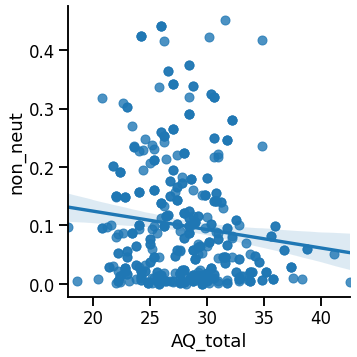

In [11]:
from scipy.stats import pearsonr, spearmanr, kendalltau, zscore, shapiro
plt_df['non_neut']=np.abs(plt_df['SubjEquiv']-.5)
r,p=spearmanr(plt_df['AQ_total'],plt_df['non_neut'])
print("R: %s P: %s"%(r,p))
sns.lmplot(x='AQ_total',y='non_neut',order=1,data=plt_df)

NEW DIST narrow 

AQ_Social
Normality AQ Statistics=0.990, p=0.091
Normality stds Statistics=0.961, p=0.000
Kendal Tau: -0.1068025630475583 P: 0.015316151267239975
Pearson R: -0.14169489691447504 P: 0.0278517353352761


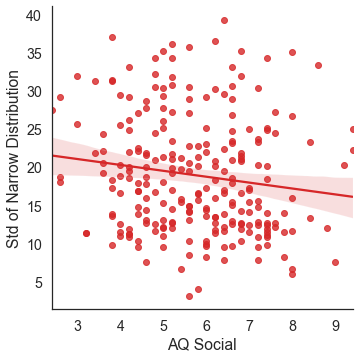

AQ_AttnDet
Normality AQ Statistics=0.985, p=0.012
Normality stds Statistics=0.961, p=0.000
Kendal Tau: -0.007027687105660327 P: 0.8734413459099564
Pearson R: 0.006271427499256523 P: 0.9228427319229534


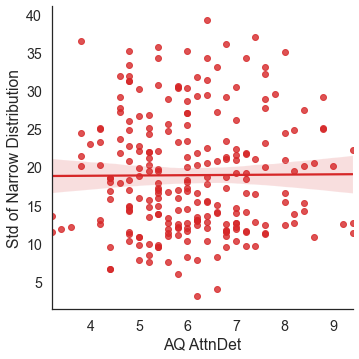

AQ_AttnSwitch
Normality AQ Statistics=0.986, p=0.020
Normality stds Statistics=0.961, p=0.000
Kendal Tau: -0.09230908550608147 P: 0.03740603771861447
Pearson R: -0.12886030226312284 P: 0.045674562532760685


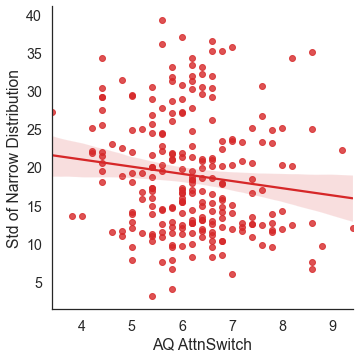

AQ_Commun
Normality AQ Statistics=0.990, p=0.092
Normality stds Statistics=0.961, p=0.000
Kendal Tau: -0.11187526283968466 P: 0.01147264162762253
Pearson R: -0.14296957379808223 P: 0.026462335070801236


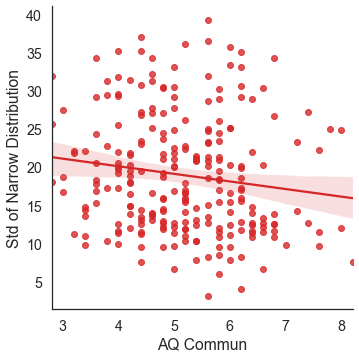

AQ_Imagine
Normality AQ Statistics=0.983, p=0.006
Normality stds Statistics=0.961, p=0.000
Kendal Tau: -0.05370791334885642 P: 0.22584988418517715
Pearson R: -0.05994057790969153 P: 0.3541740250382641


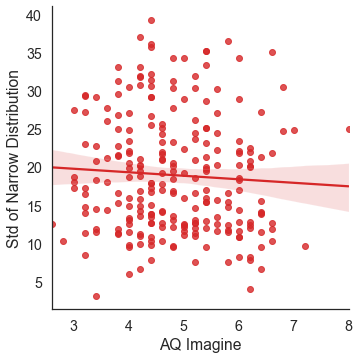

AQ_total
Normality AQ Statistics=0.986, p=0.020
Normality stds Statistics=0.961, p=0.000
Kendal Tau: -0.11276553188884172 P: 0.009561051365960862
Pearson R: -0.13467905828210333 P: 0.036668161975210625


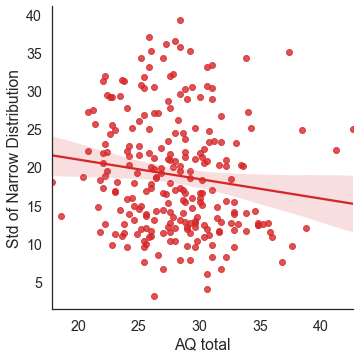

NEW DIST skew 

AQ_Social
Normality AQ Statistics=0.990, p=0.103
Normality stds Statistics=0.973, p=0.000
Kendal Tau: -0.024011348936111846 P: 0.5848017496933207
Pearson R: -0.032415122401383764 P: 0.6158208825271527


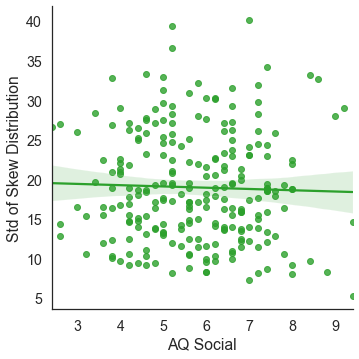

AQ_AttnDet
Normality AQ Statistics=0.986, p=0.015
Normality stds Statistics=0.973, p=0.000
Kendal Tau: -0.019430711393099834 P: 0.6588608889127204
Pearson R: -0.03362727614356352 P: 0.6026758228474363


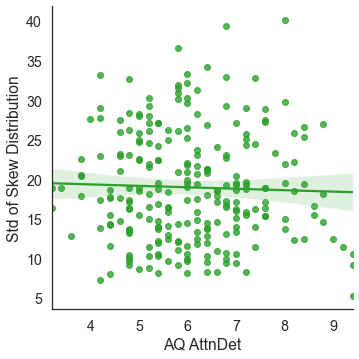

AQ_AttnSwitch
Normality AQ Statistics=0.986, p=0.019
Normality stds Statistics=0.973, p=0.000
Kendal Tau: -0.09586782997170898 P: 0.030282917928719642
Pearson R: -0.1144672520998134 P: 0.07551573865439572


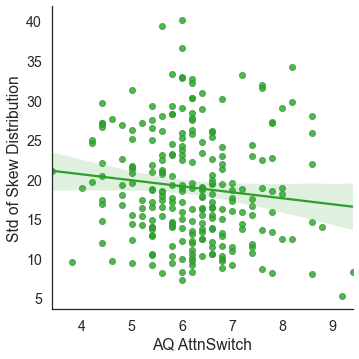

AQ_Commun
Normality AQ Statistics=0.990, p=0.101
Normality stds Statistics=0.973, p=0.000
Kendal Tau: -0.03882535640832849 P: 0.37921435525148817
Pearson R: -0.04816069928026077 P: 0.45581334763060344


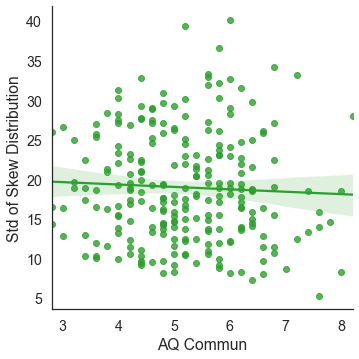

AQ_Imagine
Normality AQ Statistics=0.984, p=0.007
Normality stds Statistics=0.973, p=0.000
Kendal Tau: 0.06752129643404967 P: 0.12700108603946889
Pearson R: 0.08588056784055594 P: 0.18301395785972976


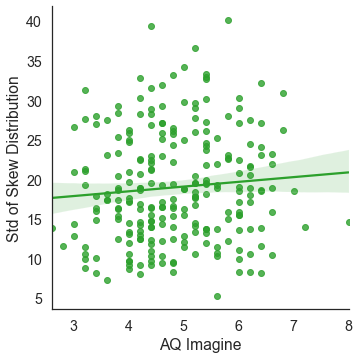

AQ_total
Normality AQ Statistics=0.986, p=0.020
Normality stds Statistics=0.973, p=0.000
Kendal Tau: -0.03074162112247147 P: 0.47895277630165256
Pearson R: -0.0438166200085197 P: 0.49750330043788293


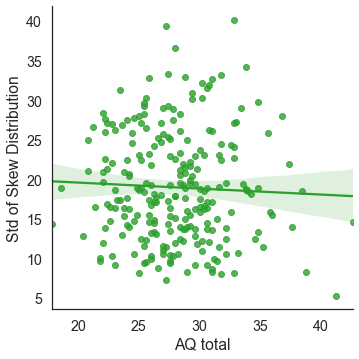

NEW DIST wide 

AQ_Social
Normality AQ Statistics=0.990, p=0.109
Normality stds Statistics=0.963, p=0.000
Kendal Tau: 0.030919207703617686 P: 0.4807732031548092
Pearson R: 0.015774907095638835 P: 0.8067245535794213


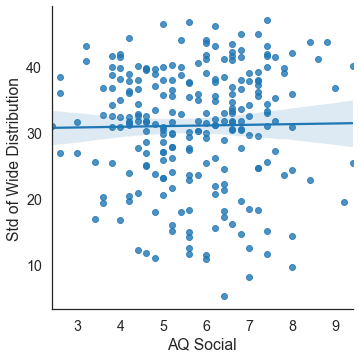

AQ_AttnDet
Normality AQ Statistics=0.985, p=0.013
Normality stds Statistics=0.963, p=0.000
Kendal Tau: 0.06400458550646339 P: 0.14509608559154683
Pearson R: 0.09622892042073668 P: 0.13470601715421682


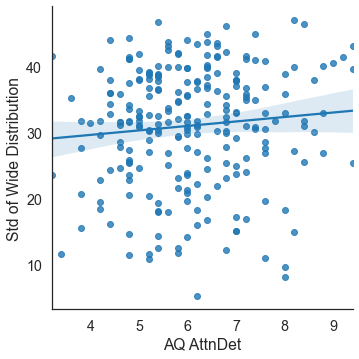

AQ_AttnSwitch
Normality AQ Statistics=0.985, p=0.011
Normality stds Statistics=0.963, p=0.000
Kendal Tau: 0.06041510636784771 P: 0.17127554730595485
Pearson R: 0.06198717394210901 P: 0.335935248586465


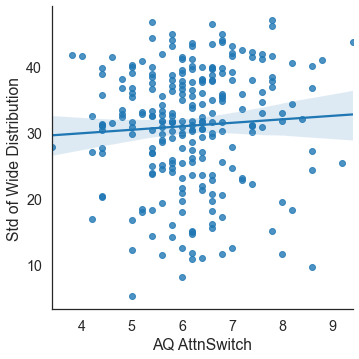

AQ_Commun
Normality AQ Statistics=0.990, p=0.095
Normality stds Statistics=0.963, p=0.000
Kendal Tau: 0.08672872052420917 P: 0.049007549946058264
Pearson R: 0.12571269654345224 P: 0.05030816971015366


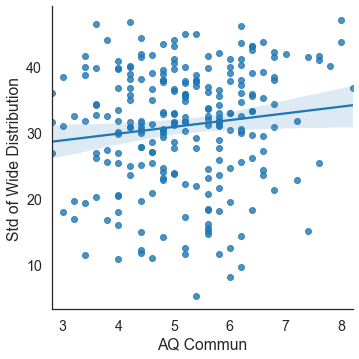

AQ_Imagine
Normality AQ Statistics=0.983, p=0.006
Normality stds Statistics=0.963, p=0.000
Kendal Tau: 0.0498697592711434 P: 0.25859139864727554
Pearson R: 0.054577986418824324 P: 0.396977688124804


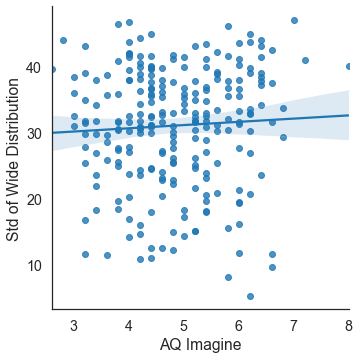

AQ_total
Normality AQ Statistics=0.987, p=0.023
Normality stds Statistics=0.963, p=0.000
Kendal Tau: 0.0924487546342228 P: 0.03286023249778061
Pearson R: 0.0999440234014016 P: 0.12022431023081653


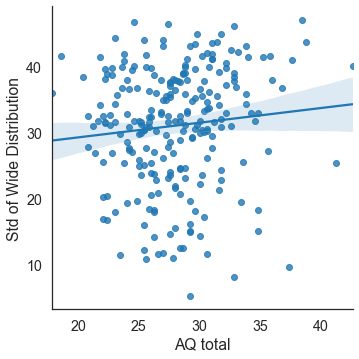

In [12]:
from scipy.stats import pearsonr, spearmanr, kendalltau, zscore, shapiro
sns.set(font_scale=1.3)
plt_df1=sub_df[sub_df['stds']>1]
for dist in sub_df['dist'].unique():
    if dist=='narrow':
        color=[plt.cm.tab10(3)]
    if dist=='wide':
        color=[plt.cm.tab10(0)]
    if dist=='skew':
        color=[plt.cm.tab10(2)]
    print('NEW DIST', dist, '\n')
    plt_df=plt_df1[plt_df1['dist'].isin([dist])]
    plt_df=plt_df.groupby(by='sub').mean()
    for aq in [aq for aq in df.columns if aq.startswith('AQ_')]:
        print(aq)
        stat, p = shapiro(plt_df[aq])
        print('Normality AQ Statistics=%.3f, p=%.3f' % (stat, p))
        stat, p = shapiro(plt_df['stds'])
        print('Normality stds Statistics=%.3f, p=%.3f' % (stat, p))
        r,p=kendalltau(plt_df[aq],plt_df['stds'])
        print("Kendal Tau: %s P: %s"%(r,p))
        r,p=pearsonr(plt_df[aq],plt_df['stds'])
        print("Pearson R: %s P: %s"%(r,p))
        with sns.axes_style("white"):
            ax=sns.lmplot(x=aq,y='stds',data=plt_df,order=1,
                       line_kws={'color': color[0]}, scatter_kws={'color': color})
            ax.set_ylabels('Std of %s Distribution'%(dist.capitalize()))
            ax.set_xlabels('%s'%(aq.replace("_", " ")))
            plt.savefig("Figures/H3b_%s_%s.svg"%(dist,aq))
            plt.show()

NEW DIST narrow 

age
Normality AQ Statistics=0.951, p=0.000
Normality stds Statistics=0.961, p=0.000
Kendal Tau: 0.16796169581815068 P: 0.00012094355793438867
Pearson R: 0.21011998807002943 P: 0.0010318598908210669


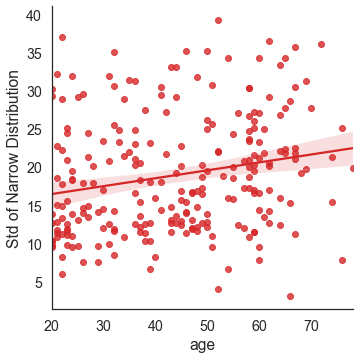

NEW DIST skew 

age
Normality AQ Statistics=0.951, p=0.000
Normality stds Statistics=0.973, p=0.000
Kendal Tau: 0.1979069529355001 P: 5.633256362710421e-06
Pearson R: 0.2870851860095573 P: 5.658072753848847e-06


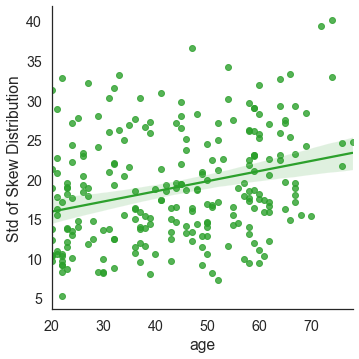

NEW DIST wide 

age
Normality AQ Statistics=0.952, p=0.000
Normality stds Statistics=0.963, p=0.000
Kendal Tau: -0.2181676980319184 P: 5.285374393704316e-07
Pearson R: -0.28979254535760246 P: 4.3678197693200505e-06


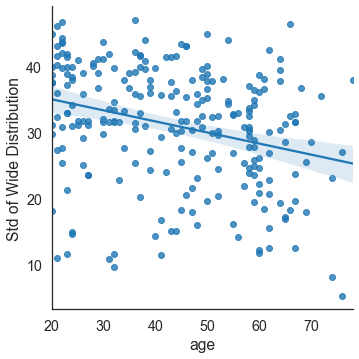

In [20]:
from scipy.stats import pearsonr, spearmanr, kendalltau, zscore, shapiro
sns.set(font_scale=1.3)
plt_df1=sub_df[sub_df['stds']>1]
for dist in sub_df['dist'].unique():
    if dist=='narrow':
        color=[plt.cm.tab10(3)]
    if dist=='wide':
        color=[plt.cm.tab10(0)]
    if dist=='skew':
        color=[plt.cm.tab10(2)]
    print('NEW DIST', dist, '\n')
    plt_df=plt_df1[plt_df1['dist'].isin([dist])]
    plt_df=plt_df.groupby(by='sub').mean()
    for aq in [aq for aq in df.columns if aq.startswith('age')]:
        print(aq)
        stat, p = shapiro(plt_df[aq])
        print('Normality AQ Statistics=%.3f, p=%.3f' % (stat, p))
        stat, p = shapiro(plt_df['stds'])
        print('Normality stds Statistics=%.3f, p=%.3f' % (stat, p))
        r,p=kendalltau(plt_df[aq],plt_df['stds'])
        print("Kendal Tau: %s P: %s"%(r,p))
        r,p=pearsonr(plt_df[aq],plt_df['stds'])
        print("Pearson R: %s P: %s"%(r,p))
        with sns.axes_style("white"):
            ax=sns.lmplot(x=aq,y='stds',data=plt_df,order=1,
                       line_kws={'color': color[0]}, scatter_kws={'color': color})
            ax.set_ylabels('Std of %s Distribution'%(dist.capitalize()))
            ax.set_xlabels('%s'%(aq.replace("_", " ")))
            plt.savefig("Figures/H3b_%s_%s.svg"%(dist,aq))
            plt.show()

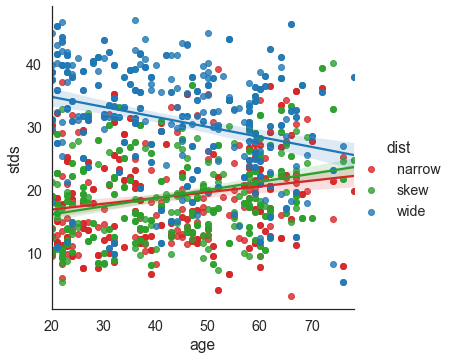

In [27]:
 with sns.axes_style("white"):
        sns.lmplot(x='age',y='stds',hue='dist',data=plt_df1,palette=['tab:red','tab:green','tab:blue'])
        plt.savefig("Figures/H3b_AllDist_%s.svg"%(aq))
        plt.show()

In [34]:
import arviz as az
trace_SREU = az.from_netcdf("trace_SREU.nc")


In [45]:
trace_SREU.posterior.data_vars['sig'].mean(["chain","draw"])


<xarray.DataArray 'sig' (Subs: 45)>
array([0.84618006, 0.45818792, 0.49623196, 0.46450465, 0.30933146,
       1.11036252, 0.49915318, 0.58071937, 0.61797425, 0.58590798,
       0.92851788, 0.56402549, 0.77490856, 0.64369842, 0.39724141,
       0.45072069, 0.37401299, 0.52190264, 0.96812346, 0.70239873,
       0.80146881, 0.49714267, 0.84543073, 1.10846648, 1.07218125,
       0.65218913, 0.75697577, 1.24789488, 0.75139792, 0.52630528,
       0.79060585, 0.14684051, 0.83490957, 0.33202919, 0.8795683 ,
       0.73609218, 0.50072042, 1.14316086, 0.77136065, 0.7666392 ,
       0.92874256, 0.79381487, 0.50590081, 1.03114283, 0.49957335])
Coordinates:
  * Subs     (Subs) object 'sub-60e5eceb989f38c746723024' ... 'sub-60fd080d54...

## Model for H3C

In [14]:
model_df=amb_df[(amb_df['full_A']==True)&(amb_df['dist']=='narrow')]

model = Lmer("choose_risk  ~ per+(1+per|sub)",
             data=model_df, family = 'binomial')

model.fit(robust='hcl')

fixedEFF_df=model.fixef.reset_index()
fixedEFF_df=fixedEFF_df.rename(columns={'index':'sub'})
sub_df=sub_df.merge(fixedEFF_df[['sub','(Intercept)','per']],on='sub')
sub_df.head()

Formula: choose_risk~per+(1+per|sub)

Family: binomial	 Inference: parametric

Number of observations: 3735	 Groups: {'sub': 249.0}

Log-likelihood: -2049.153 	 AIC: 4108.307

Random effects:

            Name       Var     Std
sub  (Intercept)   426.361  20.649
sub          per  1601.867  40.023

             IV1  IV2   Corr
sub  (Intercept)  per -0.978

Fixed effects:



,index_x,dist,narrow_first,means,stds,skew,sub,index_y,USIDep,AQ_Social,...,AADIS7,AADIS8,AADIS9,AADIS10,AADIS11,AADIS12,(Intercept)_x,per_x,(Intercept)_y,per_y
0,0,narrow,-1.0,50.000000,33.166248,0.000000,sub-5858b2ca83a02d0001e38fd2,103,1,4.2,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,-48.552572,96.702183,-48.552572,96.702183
1,1,skew,-1.0,71.764706,14.677915,-0.209272,sub-5858b2ca83a02d0001e38fd2,103,1,4.2,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,-48.552572,96.702183,-48.552572,96.702183
2,2,wide,-1.0,48.000000,36.292463,0.123724,sub-5858b2ca83a02d0001e38fd2,103,1,4.2,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,-48.552572,96.702183,-48.552572,96.702183
3,0,narrow,-1.0,59.166667,19.286516,0.505403,sub-5c7e764fa7432a00169e1499,385,1,5.2,...,Never Used,Once or Twice,Never Used,Never Used,Never Used,Once or Twice,-48.949229,98.937704,-48.949229,98.937704
4,1,skew,-1.0,47.058824,27.102746,-0.458493,sub-5c7e764fa7432a00169e1499,385,1,5.2,...,Never Used,Once or Twice,Never Used,Never Used,Never Used,Once or Twice,-48.949229,98.937704,-48.949229,98.937704


## Hypothesis 3 c:
- Variance of an individual’s reported belief about the probabilities mediates the relationship between autistic traits and ambiguity aversion.  

In [15]:
from pingouin import mediation_analysis, read_dataset

model_df=sub_df[sub_df['dist'].isin(['narrow'])]
model_df=model_df.groupby(by='sub').mean()
model_df['EP_n']=np.divide(np.negative(model_df['(Intercept)']),model_df['per'])
aqs=[aq for aq in model_df.columns if aq.startswith('AQ_')]
aqs.append('ASD')

for aq in aqs:
    print(aq)
    res=mediation_analysis(data=model_df, x=aq, m='stds', y='EP_n', alpha=0.05,seed=42)
    display(res)

/home/strange/anaconda3/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.25.10) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


KeyError: '(Intercept)'

# Mediation of the wide distribution

In [ ]:
model_df=amb_df[(amb_df['full_A']==True)&(amb_df['dist']=='wide')]

model = Lmer("choose_risk  ~ per+(1+per|sub)",
             data=model_df, family = 'binomial')

model.fit(robust='hcl')

fixedEFF_df=model.fixef.reset_index()
fixedEFF_df=fixedEFF_df.rename(columns={'index':'sub'})
sub_df=sub_df.merge(fixedEFF_df[['sub','(Intercept)','per']],on='sub')
sub_df.head()

In [ ]:

model_df=sub_df[sub_df['dist'].isin(['narrow'])]
model_df=model_df.groupby(by='sub').mean()
model_df['EP_w']=np.divide(np.negative(model_df['(Intercept)_y']),model_df['per_y'])
aqs=[aq for aq in model_df.columns if aq.startswith('AQ_')]

for aq in aqs:
    print(aq)
    res=mediation_analysis(data=model_df, x=aq, m='stds', y='EP_w', alpha=0.05,seed=42)
    display(res)

## SUPER EXPLORATORY

In [ ]:
from scipy.stats import pearsonr, spearmanr, kendalltau, zscore, shapiro
sns.set(font_scale=1.3)

for dist in sub_df['dist'].unique():
    if dist=='narrow':
        color=[plt.cm.tab10(0)]
    if dist=='wide':
        color=[plt.cm.tab10(1)]
    if dist=='skew':
        color=[plt.cm.tab10(2)]
    print('NEW DIST', dist, '\n')
    plt_df=sub_df[sub_df['dist'].isin([dist])]
    plt_df=plt_df.groupby(by='sub').mean()
    for aq in [aq for aq in ['age','USIDep']]:
        print(aq)
        stat, p = shapiro(plt_df[aq])
        print('Normality AQ Statistics=%.3f, p=%.3f' % (stat, p))
        stat, p = shapiro(plt_df['stds'])
        print('Normality stds Statistics=%.3f, p=%.3f' % (stat, p))
        
        with sns.axes_style("darkgrid"):
            r,p=kendalltau(plt_df[aq],plt_df['stds'])
            print("Kendal Tau: %s P: %s"%(r,p))
            r,p=pearsonr(plt_df[aq],plt_df['stds'])
            print("Pearson R: %s P: %s"%(r,p))
            ax=sns.lmplot(x=aq,y='stds',data=plt_df,order=1,
                       line_kws={'color': color[0]}, scatter_kws={'color': color})
            ax.set_ylabels('Std of %s Distribution'%(dist.capitalize()))
            ax.set_xlabels('%s'%(aq.replace("_", " ")))
            plt.show()
            r,p=kendalltau(plt_df[aq],plt_df['means'])
            print("Kendal Tau: %s P: %s"%(r,p))
            r,p=pearsonr(plt_df[aq],plt_df['means'])
            print("Pearson R: %s P: %s"%(r,p))
            ax=sns.lmplot(x=aq,y='means',data=plt_df,order=1,
                       line_kws={'color': color[0]}, scatter_kws={'color': color})
            ax.set_ylabels('Mean of %s Distribution'%(dist.capitalize()))
            ax.set_xlabels('%s'%(aq.replace("_", " ")))
            plt.savefig("Figures/H3b_%s_%s.svg"%(dist,aq))
            plt.show()

In [ ]:
from scipy.stats import ttest_ind,kruskal

for dist in sub_df['dist'].unique():
    if dist=='narrow':
        color=[plt.cm.tab10(0)]
    if dist=='wide':
        color=[plt.cm.tab10(1)]
    if dist=='skew':
        color=[plt.cm.tab10(2)]
    print('NEW DIST', dist, '\n')
    plt_df=sub_df[sub_df['dist'].isin([dist])]
    for aq in [aq for aq in ['sex','education']]:
        
        with sns.axes_style("white"):
            
            fig, ax = plt.subplots(figsize=[10,10])
            sns.barplot(x=aq,y='stds',ax=ax,data=plt_df,)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
            plt.tight_layout()
            plt.show()


In [ ]:
df=sub_df
df

In [ ]:
narrow_d=[20,30,30,40,40,40,50,50,50,50,50,50,50,50,50,50,60,60,60,70,70,80];
wide_d=[0,0,0,0,0,10,10,10,20,20,30,70,80,80,90,90,90,100,100,100,100,100];
skew_d=[x+20 for x in narrow_d]

df=sub_df[sub_df['stds']>1]
df['True Mean'] = 0
df.loc[df['dist']=='narrow', 'True Mean'] = 50
df.loc[df['dist']=='wide', 'True Mean'] = 50
df.loc[df['dist']=='skew', 'True Mean'] = 70
df['True Deviation'] = 0
df.loc[df['dist']=='narrow', 'True Deviation'] = np.std(narrow_d)
df.loc[df['dist']=='wide', 'True Deviation'] = np.std(wide_d)
df.loc[df['dist']=='skew', 'True Deviation'] = np.std(skew_d)


df['Accuracy Mean']=df['means']-df['True Mean']
df['Accuracy Deviation']=df['stds']-df['True Deviation']
df=df[~df['stds'].isna()]


In [ ]:
sns.swarmplot(x='True Mean',y='Accuracy Deviation',dodge=True, hue='dist',data=df,
              hue_order=['narrow','wide','skew'],palette=['tab:red','tab:blue','tab:green'])
from scipy.stats import ttest_1samp, pearsonr

r,p=pearsonr(df['means'],df['True Mean'])
print(r,p)
r,p=pearsonr(df['stds'],df['True Deviation'])
print(r,p)
for dist in full_df['dist'].unique():
    print(dist)
    t,p=ttest_1samp(df[df['dist']==dist]['Accuracy Mean'],0)
    print(t,p)
for dist in full_df['dist'].unique():
    print(dist)
    t,p=ttest_1samp(df[df['dist']==dist]['Accuracy Deviation'],0)
    print(t,p)

In [ ]:
df['True Mean']

/home/strange/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.8, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/strange/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
